In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install tensorflow==2.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 31.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-serve

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
import random
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import os

data_path = '/content/drive/My Drive/Minor/FF++'
for folder in os.listdir(data_path):
    print(folder, "contains:", os.listdir(os.path.join(data_path, folder))[:5])


fake contains: ['01_11__secret_conversation__4OJNJLOO.mp4', '01_11__talking_against_wall__9229VVZ3.mp4', '01_02__walk_down_hall_angry__YVGY8LOK.mp4', '01_03__podium_speech_happy__480LQD1C.mp4', '01_11__meeting_serious__9OM3VE0Y.mp4']
real contains: ['01__outside_talking_still_laughing.mp4', '01__outside_talking_pan_laughing.mp4', '01__kitchen_pan.mp4', '01__exit_phone_room.mp4', '01__meeting_serious.mp4']


In [ ]:
import os

data_path = '/content/drive/My Drive/Minor/FF++'
real_path = os.path.join(data_path, 'real')
fake_path = os.path.join(data_path, 'fake')

# List videos
real_videos = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith('.mp4')]
fake_videos = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith('.mp4')]

print(f"Number of real videos: {len(real_videos)}")
print(f"Number of fake videos: {len(fake_videos)}")


Number of real videos: 200
Number of fake videos: 200


In [ ]:
import numpy as np
import cv2
import os

# Paths to image directories
real_path = '/content/drive/My Drive/Minor/FF++/real'
fake_path = '/content/drive/My Drive/Minor/FF++/fake'

# List all images in the directories
real_images = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith('.mp4')]
fake_images = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith('.mp4')]

# Load images and preprocess them
def load_images(image_paths):
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)  # Read image
        image = cv2.resize(image, (224, 224))  # Resize image to a consistent shape (e.g., 224x224)
        images.append(image)
    return np.array(images)

real_images_data = load_images(real_images)
fake_images_data = load_images(fake_images)

# Concatenate real and fake images
data = np.concatenate((real_images_data, fake_images_data), axis=0)

# Create labels (0 for real, 1 for fake)
real_labels = np.zeros(len(real_images_data))
fake_labels = np.ones(len(fake_images_data))

# Concatenate labels
labels = np.concatenate((real_labels, fake_labels), axis=0)

# Save data and labels as .npy files
np.save('/content/drive/My Drive/Minor/data_ff.npy', data)
np.save('/content/drive/My Drive/Minor/label_ff.npy', labels)

print(f"Data saved with {data.shape[0]} images and {labels.shape[0]} labels.")


In [ ]:
import numpy as np
import cv2
import os

# Paths to video directories
real_path = '/content/drive/My Drive/Minor/FF++/real'
fake_path = '/content/drive/My Drive/Minor/FF++/fake'

# List all video files in the directories
real_videos = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith('.mp4')]
fake_videos = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith('.mp4')]

# Function to extract frames from videos
def extract_frames(video_paths, frame_count=1):
    frames = []
    for video_path in video_paths:
        cap = cv2.VideoCapture(video_path)
        success, frame = cap.read()
        frame_idx = 0
        while success and frame_idx < frame_count:
            resized_frame = cv2.resize(frame, (224, 224))
            frames.append(resized_frame)
            success, frame = cap.read()
            frame_idx += 1
        cap.release()
    return np.array(frames)

# Extract frames and preprocess
real_images_data = extract_frames(real_videos, frame_count=1)  # 1 frame per video
fake_images_data = extract_frames(fake_videos, frame_count=1)

# Concatenate real and fake images
data = np.concatenate((real_images_data, fake_images_data), axis=0)

# Create labels
real_labels = np.zeros(len(real_images_data))
fake_labels = np.ones(len(fake_images_data))
labels = np.concatenate((real_labels, fake_labels), axis=0)

# Save data and labels as .npy files
np.save('/content/drive/My Drive/Minor/data_ff.npy', data)
np.save('/content/drive/My Drive/Minor/label_ff.npy', labels)

print(f"Data saved with {data.shape[0]} frames and {labels.shape[0]} labels.")


Data saved with 400 frames and 400 labels.


In [ ]:
data = np.load ('/content/drive/My Drive/Minor/data_ff.npy',mmap_mode='r')
labels = np.load ('/content/drive/My Drive/Minor/label_ff.npy',mmap_mode='r')

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (400, 224, 224, 3)
Labels shape: (400,)


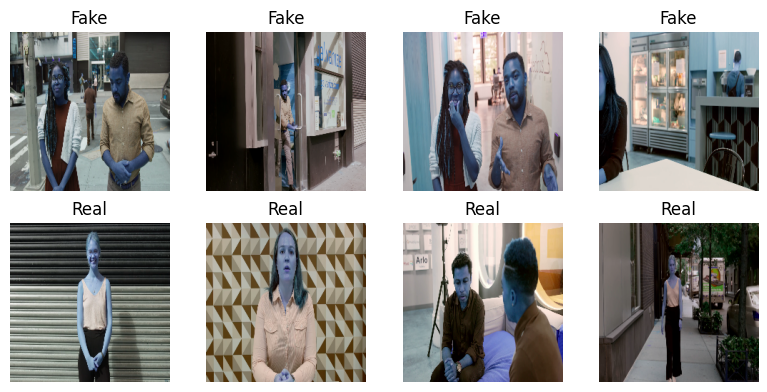

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique class labels in the labels array (e.g., 0 for Fake, 1 for Real)
unique_classes = np.unique(labels)

# Create a dictionary to store four random data samples from each class
class_samples = {}

# Map class indices to their corresponding names
class_names = {0: "Fake", 1: "Real"}

# Select four random data samples from each class
for class_label in unique_classes:
    class_indices = np.where(labels == class_label)[0]  # Get indices for each class
    random_indices = np.random.choice(class_indices, 4, replace=False)  # Randomly select 4 indices
    class_samples[class_label] = [data[index] for index in random_indices]

# Plot the randomly selected images in 2 rows and 4 columns
plt.figure(figsize=(8, 4))  # Adjust figure size as needed
for i, (class_label, image_data_list) in enumerate(class_samples.items()):
    class_name = class_names[class_label]  # Get the corresponding class name
    for j, image_data in enumerate(image_data_list):
        plt.subplot(2, 4, i * 4 + j + 1)
        plt.imshow(image_data)
        plt.title(f'{class_name}')
        plt.axis('off')

plt.tight_layout()
plt.show()


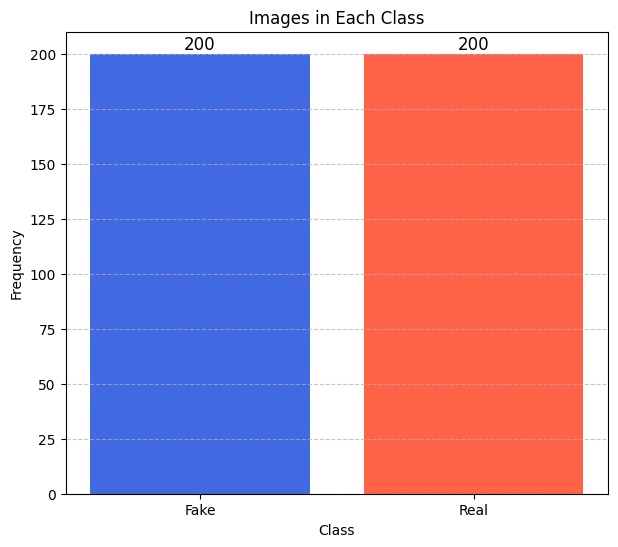

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming labels is a 1D array of class indices (e.g., [0, 1, 1, 0, ...]) or one-hot encoded
if len(labels.shape) == 1:
    # If labels are flat, count occurrences of each class
    class_counts = np.bincount(labels.astype(int))
else:
    # If labels are one-hot encoded, sum along the rows
    class_counts = np.sum(labels, axis=0)

# Map class indices to their corresponding names
class_names = {0: "Fake", 1: "Real"}

# Define custom colors for each class
colors = ['royalblue', 'tomato']

# Plot the class frequencies with custom colors
plt.figure(figsize=(7, 6))
bars = plt.bar(
    [class_names[class_idx] for class_idx in range(len(class_counts))],
    class_counts,
    color=colors
)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in Each Class')

# Annotate the bars with the class frequencies (integer format)
for bar, count in zip(bars, class_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        count,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()


In [ ]:
# Split the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, stratify = labels, random_state = 42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, stratify = train_labels, random_state = 42)

In [ ]:
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)

train_data shape: (324, 224, 224, 3)
train_labels shape: (324,)
val_data shape: (36, 224, 224, 3)
val_labels shape: (36,)
test_data shape: (40, 224, 224, 3)
test_labels shape: (40,)


In [ ]:
print(train_labels.shape)  # Check the shape of train_labels
print(val_labels.shape)    # Check the shape of val_labels
print(test_labels.shape)   # Check the shape of test_labels


(324,)
(36,)
(40,)


In [ ]:
from keras.utils import to_categorical

# If labels are integer-encoded, you can convert them to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

print(train_labels.shape)  # Should print (num_samples, 2)


(324, 2)


In [ ]:
class_names_mapping = { 0: "Fake", 1: "Real" }
# Calculate class distribution in each set
num_classes = train_labels.shape[1]
class_counts_train = np.sum(train_labels, axis=0)
class_counts_val = np.sum(val_labels, axis=0)
class_counts_test = np.sum(test_labels, axis=0)

class_counts_mapping = {}
for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name] = {'Train': class_counts_train[index]}

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Validation'] = class_counts_val[index]

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Test'] = class_counts_test[index]

# Print class distribution mapping
for class_name, counts in class_counts_mapping.items():
    print(class_name)
    for set_name, count in counts.items():
        print(f" - {set_name}: {count}")

Fake
 - Train: 162.0
 - Validation: 18.0
 - Test: 20.0
Real
 - Train: 162.0
 - Validation: 18.0
 - Test: 20.0


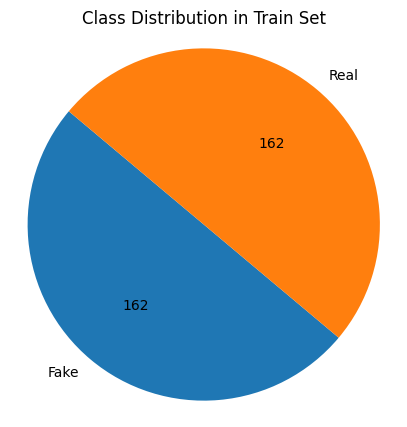

In [ ]:
# Create pie charts for each set
for set_name in ['Train']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

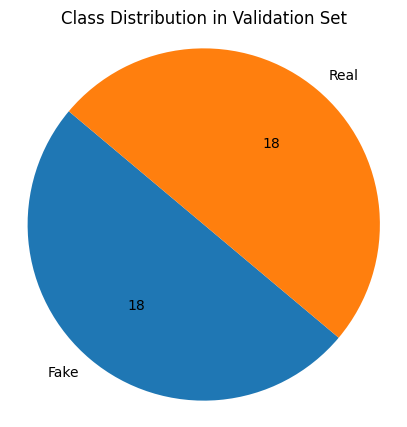

In [ ]:
# Create pie charts for each set
for set_name in ['Validation']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


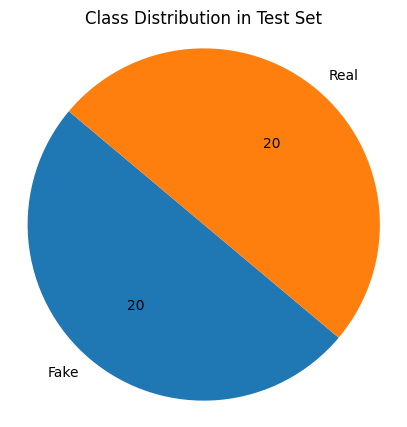

In [ ]:
# Create pie charts for each set
for set_name in ['Test']:
    class_counts = [counts[set_name] for counts in class_counts_mapping.values()]
    class_labels = list(class_counts_mapping.keys())

    plt.figure(figsize=(5, 5))
    plt.pie(class_counts, labels=class_labels, startangle=140, autopct=lambda p: '{:.0f}'.format(p * sum(class_counts) / 100))
    plt.title(f'Class Distribution in {set_name} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [ ]:
# Convert one-hot encoded labels to class labels
train_labels_encoded = np.argmax(train_labels, axis=1)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded)

# Create a dictionary of class weights to use in your model training
class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 1.0, 1: 1.0}

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5,mode='max', min_lr = 1e-4,verbose = 1)
#early_stop = EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
saved_model = ('/content/drive/MyDrive/Minor/InceptionResNet_ff.h5')
model_chkpt = ModelCheckpoint(saved_model ,save_best_only = True, monitor = 'val_accuracy',verbose = 1)

# callback_list = [early_stop, model_chkpt, lr_reduce]
callback_list = [model_chkpt, lr_reduce]

In [ ]:
base_model = InceptionResNetV2(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

219055592/219055592 [==============================] - 6s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Minor/InceptionResNet_ff.h5')

In [ ]:
epochs = 10
batch_size = 16

In [ ]:
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict)

Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 0.8201 - accuracy: 0.5556 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/Minor/InceptionResNet_ff.h5
21/21 [==============================] - 429s 19s/step - loss: 0.8201 - accuracy: 0.5556 - val_loss: 50279.6211 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.4846 
Epoch 2: val_accuracy improved from 0.50000 to 0.52778, saving model to /content/drive/MyDrive/Minor/InceptionResNet_ff.h5
21/21 [==============================] - 416s 20s/step - loss: 0.7438 - accuracy: 0.4846 - val_loss: 4.5536 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5432 
Epoch 3: val_accuracy did not improve from 0.52778
21/21 [==============================] - 391s 18s/step - loss: 0.6874 - accuracy: 0.5432 - val_loss: 25.8860 - val_accuracy: 0.5000 

Text(0.5, 1.0, 'Training and validation loss')

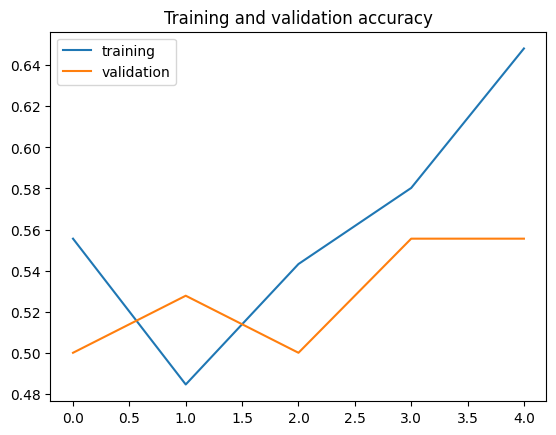

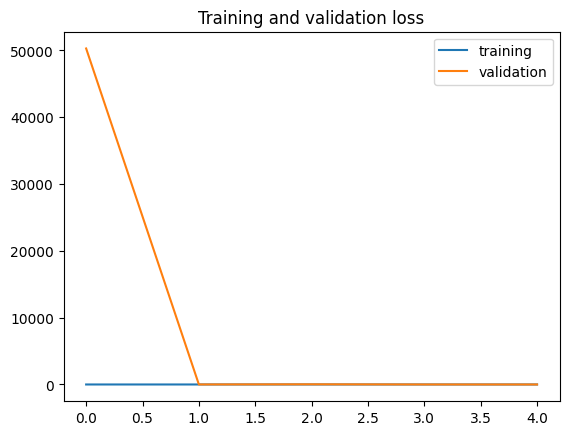

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
last_saved_epoch = 5
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict,
                    initial_epoch = last_saved_epoch)

Epoch 6/10
21/21 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.6142 
Epoch 6: val_accuracy did not improve from 0.55556
21/21 [==============================] - 415s 19s/step - loss: 0.6520 - accuracy: 0.6142 - val_loss: 1.1235 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/10
21/21 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.6636 
Epoch 7: val_accuracy did not improve from 0.55556
21/21 [==============================] - 392s 19s/step - loss: 0.6214 - accuracy: 0.6636 - val_loss: 88.9454 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 8/10
21/21 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.6296 
Epoch 8: val_accuracy did not improve from 0.55556
21/21 [==============================] - 389s 18s/step - loss: 0.6129 - accuracy: 0.6296 - val_loss: 7.0770 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 9/10
21/21 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.7099 
Epoch 9: val_accuracy improved fro

Text(0.5, 1.0, 'Training and validation loss')

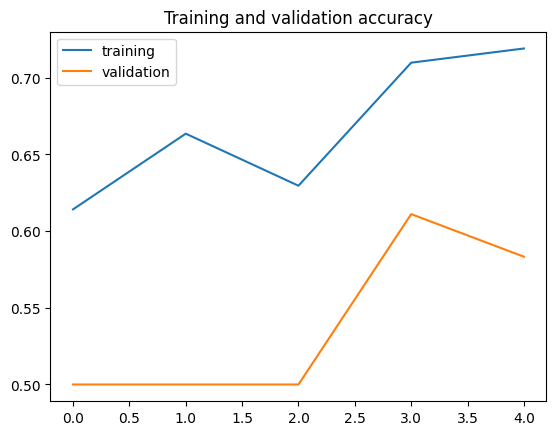

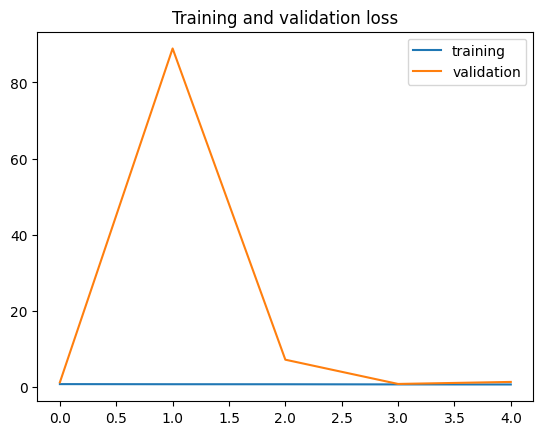

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
epochs = 15
batch_size = 16

In [ ]:
last_saved_epoch = 10
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict,
                    initial_epoch = last_saved_epoch)

Epoch 11/15
21/21 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.7778 
Epoch 11: val_accuracy did not improve from 0.61111
21/21 [==============================] - 388s 18s/step - loss: 0.4939 - accuracy: 0.7778 - val_loss: 0.6366 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 12/15
21/21 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.6728 
Epoch 12: val_accuracy did not improve from 0.61111
21/21 [==============================] - 397s 19s/step - loss: 0.5949 - accuracy: 0.6728 - val_loss: 4.2471 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 13/15
21/21 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7099 
Epoch 13: val_accuracy did not improve from 0.61111
21/21 [==============================] - 393s 19s/step - loss: 0.5720 - accuracy: 0.7099 - val_loss: 2.3868 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 14/15
21/21 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.6728 
Epoch 14: val_accuracy impro

Text(0.5, 1.0, 'Training and validation loss')

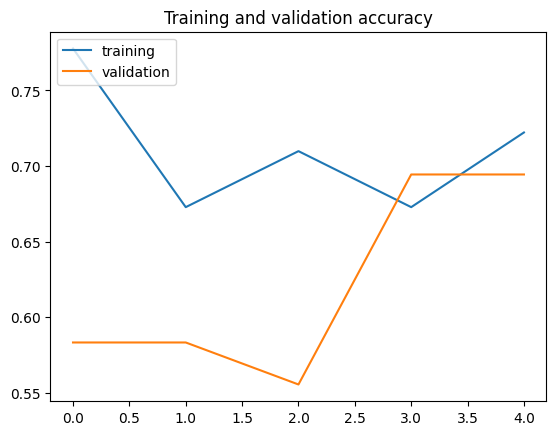

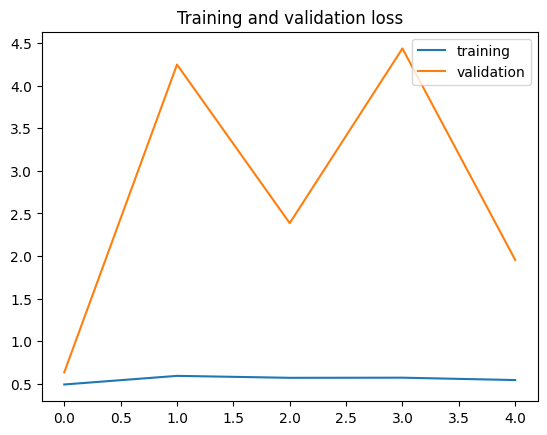

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
# Example for displaying metrics over 10 epochs
print("Epoch-wise Metrics:\n")
print("Epoch | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss")
print("-" * 65)

for epoch in range(len(acc)):  # Adjusts to the length of acc (number of epochs)
    print(f"{epoch+1:5d} | {acc[epoch]:17.4f} | {val_acc[epoch]:19.4f} | {loss[epoch]:13.4f} | {val_loss[epoch]:15.4f}")


Epoch-wise Metrics:

Epoch | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss
-----------------------------------------------------------------
    1 |            0.7778 |              0.5833 |        0.4939 |          0.6366
    2 |            0.6728 |              0.5833 |        0.5949 |          4.2471
    3 |            0.7099 |              0.5556 |        0.5720 |          2.3868
    4 |            0.6728 |              0.6944 |        0.5736 |          4.4355
    5 |            0.7222 |              0.6944 |        0.5457 |          1.9557


In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 12s 2s/step - loss: 2.4683 - accuracy: 0.6250
Test Accuracy: 0.625


In [ ]:
# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions and true labels to integer format
predicted_labels = np.argmax(predictions, axis=1)
# test_labels = test_data.classes
true_labels = np.argmax(test_labels, axis=1)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)

2/2 [==============================] - 20s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        20
           1       0.57      1.00      0.73        20

    accuracy                           0.62        40
   macro avg       0.79      0.62      0.56        40
weighted avg       0.79      0.62      0.56        40



In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, np.round(predicted_labels))

cm

array([[ 5, 15],
       [ 0, 20]])

Confusion matrix, without normalization


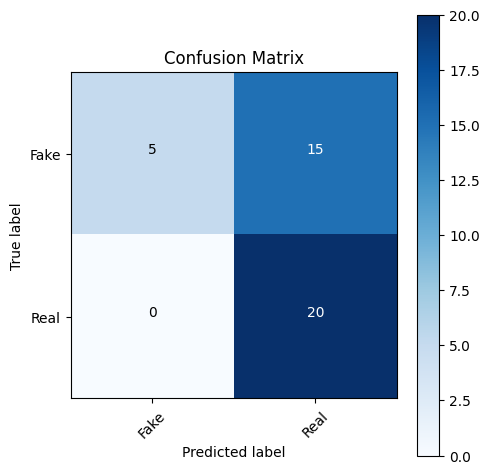

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    print('Confusion matrix, without normalization')

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'  # Remove '.2f' format for non-normalized values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_plot_labels = ["Fake", "Real"]

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
plt.show()


In [ ]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.0 MB/s eta 0:00:00


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
gpus = [device.name for device in device_list if device.device_type == 'GPU']
print('TensorFlow recognized {} GPUs'.format(len(gpus)))

TensorFlow recognized 0 GPUs


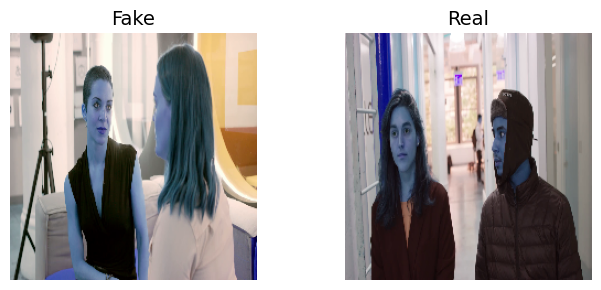

In [ ]:
binary_labels = ["Fake", "Real"]

# Convert one-hot encoded labels to integer labels
test_labels_int = np.argmax(test_labels, axis=1)

# Create an array to store the images
image_array = []

# Create subplots for 2 images in a single row (1 real and 1 fake)
num_images = 2
fig, ax = plt.subplots(1, num_images, figsize=(7, 3))

for i in range(2):  # Loop through binary classes: "Real" and "Fake"
    # Find indices of images for the current class
    class_indices = np.where(test_labels_int == i)[0]
    random_index = np.random.choice(class_indices, 1, replace=False)  # Choose 1 random index

    # Display the image from test data
    img = test_data[random_index[0]]
    image_array.append(img)  # Store the image in the array

    ax[i].imshow(img)
    ax[i].set_title(binary_labels[i], fontsize=14)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

# Now you can preprocess the image_array as needed with base_preprocess function
X = base_preprocess(np.array(image_array))

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear


In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 1])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1])

SMOOTHGRAD

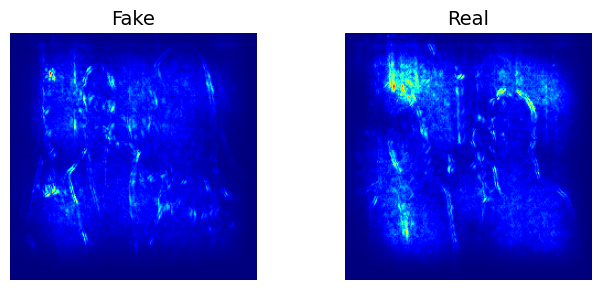

CPU times: user 1min 45s, sys: 1.97 s, total: 1min 47s
Wall time: 1min 25s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# Generate saliency maps with smoothing that reduces noise by adding noise
saliency_maps = saliency(score,
                         X,
                         smooth_samples=20,
                         smooth_noise=0.20)

# Calculate the number of images
num_images = len(binary_labels)

# Create a single row plot
# fig, axes = plt.subplots(1, num_images, figsize=(7, 3))
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    axes[i].set_title(title, fontsize=14)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


GRADCAM

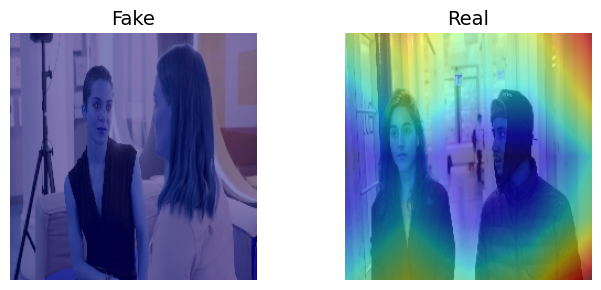

CPU times: user 13.3 s, sys: 208 ms, total: 13.5 s
Wall time: 12.3 s


In [ ]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(image_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()


GRADCAM++

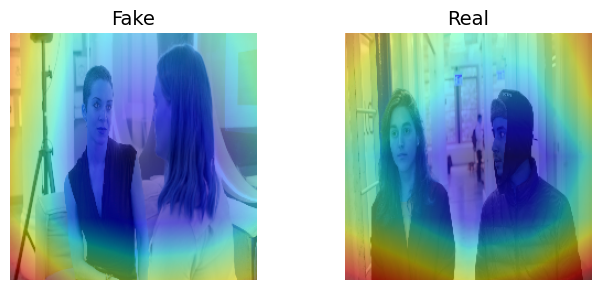

CPU times: user 14.9 s, sys: 245 ms, total: 15.1 s
Wall time: 14.8 s


In [ ]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(image_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

FASTER SCORE CAM

1/1 [==============================] - 10s 10s/step


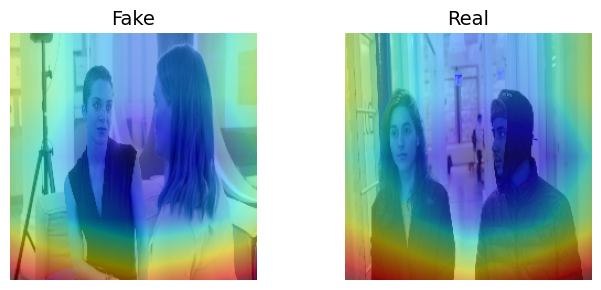

CPU times: user 23.8 s, sys: 317 ms, total: 24.1 s
Wall time: 19.6 s


In [ ]:
%%time

from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(image_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()
